In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [57]:
# Cargar el dataset MNIST
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

validation_split = 0.1  
num_val_samples = int(validation_split * len(x_train))
x_val_noisy = x_train_noisy[-num_val_samples:]
x_val = x_train[-num_val_samples:]
x_train_noisy = x_train_noisy[:-num_val_samples]
x_train = x_train[:-num_val_samples]

input_img = tf.keras.layers.Input(shape=(28, 28, 1))

# Encoder
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')

(60000, 28, 28)


In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val_noisy, x_val))

313/313 [==============================] - 3s 11ms/step


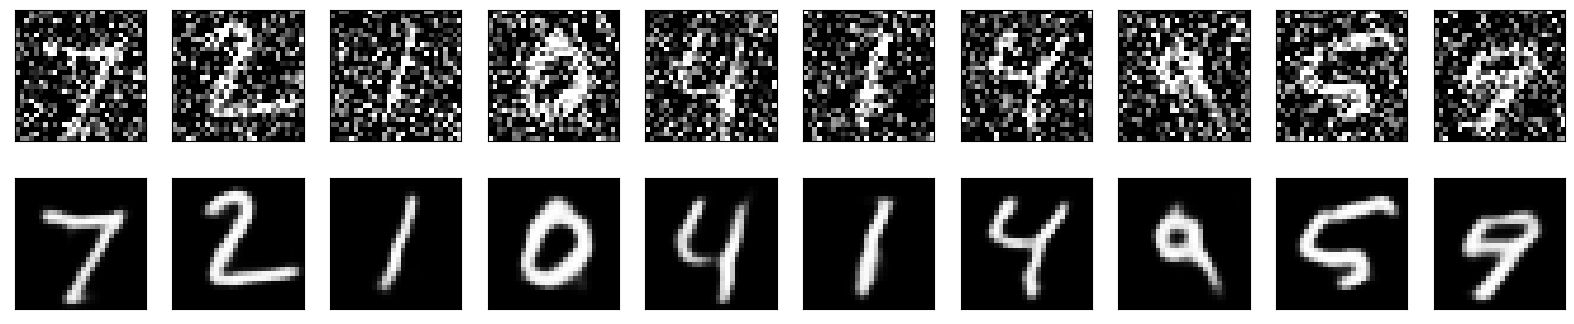

In [7]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [2]:
from PIL import Image, ImageDraw, ImageFilter
import random

In [3]:
def add_blur(img):
    """
    Aplica difuminación a zonas específicas de una imagen RGB con formas aleatorias.
    """
    # Convertir a objeto Image para facilitar el dibujo de formas y manipulación
    image_pil = Image.fromarray(img.astype('uint8'))
    
    # Crear una máscara para aplicar la difuminación
    mask = Image.new('L', image_pil.size, 0)
    draw = ImageDraw.Draw(mask)
    shape_type = random.choice(['circle', 'rectangle', 'ellipse'])

    if shape_type == 'circle':
        radius = random.randint(20, min(image_pil.width, image_pil.height) // 4)
        x, y = random.randint(radius, image_pil.width - radius), random.randint(radius, image_pil.height - radius)
        draw.ellipse([x - radius, y - radius, x + radius, y + radius], fill=255)
    elif shape_type == 'rectangle':
        x0, y0 = random.randint(0, image_pil.width // 2), random.randint(0, image_pil.height // 2)
        x1, y1 = random.randint(x0 + 20, image_pil.width), random.randint(y0 + 20, image_pil.height)
        draw.rectangle([x0, y0, x1, y1], fill=255)
    elif shape_type == 'ellipse':
        x0, y0 = random.randint(0, image_pil.width // 2), random.randint(0, image_pil.height // 2)
        x1, y1 = random.randint(x0 + 20, image_pil.width), random.randint(y0 + 20, image_pil.height)
        draw.ellipse([x0, y0, x1, y1], fill=255)

    # Aplicar la difuminación donde la máscara es blanca
    blurred_image = image_pil.filter(ImageFilter.GaussianBlur(radius=4))
    mask = np.array(mask)
    original = np.array(image_pil)
    blurred = np.array(blurred_image)

    # Combinar la imagen original y la difuminada según la máscara
    combined = np.where(mask[:, :, None] == 255, blurred, original)

    return combined / 255.0  # Normaliza la salida a 0-1

In [8]:
def custom_image_generator(image_filenames, batch_size, target_size):
    while True:
        np.random.shuffle(image_filenames)
        
        for i in range(0, len(image_filenames), batch_size):
            batch_filenames = image_filenames[i:i + batch_size]
            batch_images = []
            batch_labels = []
            
            for fname in batch_filenames:
                img = tf.keras.preprocessing.image.load_img(fname, target_size=target_size)
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                
                batch_images.append(add_blur(img_array))
                batch_labels.append(img_array * (1./255))  # Usar la imagen original como etiqueta
            
            batch_images = np.array(batch_images)
            batch_labels = np.array(batch_labels)
            
            yield (batch_images, batch_labels)

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=add_blur)

train_image_filenames = [os.path.join('D:\\Flickr30k\\flickr30k_images\\flickr30k_images\\Train\\images', fname) for fname in os.listdir('D:\\Flickr30k\\flickr30k_images\\flickr30k_images\\Train\\images')]

train_generator = custom_image_generator(train_image_filenames
                                         , batch_size=128
                                         , target_size=(256, 256))

print(len(train_image_filenames))


validation_image_filenames = [os.path.join('D:\\Flickr30k\\flickr30k_images\\flickr30k_images\\Validation\\images', fname) for fname in os.listdir('D:\\Flickr30k\\flickr30k_images\\flickr30k_images\\Validation\\images')]

validation_generator = custom_image_generator(validation_image_filenames
                                         , batch_size=128
                                         , target_size=(256, 256))

print(len(validation_image_filenames))

input_img = tf.keras.layers.Input(shape=(256, 256, 3))  # 3 canales para RGB

# Modelo VGG16 con pesos preentrenados de ImageNet
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=input_img)

for layer in vgg.layers:
    layer.trainable = False

# Encoder
encoder_output = vgg.get_layer('block3_pool').output

# Decoder
x = tf.keras.layers.UpSampling2D((2, 2))(encoder_output)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.models.Model(vgg.input, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

26783
5000


In [10]:
autoencoder.fit(
    train_generator,
    steps_per_epoch=len(train_image_filenames) // 128,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_image_filenames) // 128
)

Epoch 1/10
  2/209 [..............................] - ETA: 2:57:53 - loss: 0.2666

In [ ]:
image_path = "D:\\Flickr30k\\flickr30k_images\\flickr30k_images\\23775702.jpg"
image_pil = Image.open(image_path)
image_pil = image_pil.resize((256, 256))
image = np.array(image_pil)

noisy_image = add_blur(image)

noisy_image = np.expand_dims(noisy_image, axis=0)

image_recover = autoencoder.predict(noisy_image)

noisy_image = np.squeeze(noisy_image, axis=0)
image_recover = np.squeeze(image_recover, axis=0)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(image / 255.0)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_image)
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_recover)
plt.title('Image Recover')
plt.axis('off')

plt.show()